# パッケージを導入します。

In [8]:
import tensorrt as trt
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
import os
import cv2
import matplotlib.pyplot as plt

# TensorRTのengineファイルを導入するための関数定義

In [9]:
def load_engine(engine_file_path):
    # Create a TensorRT logger
    TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

    # Deserialize the engine from file
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        engine = runtime.deserialize_cuda_engine(f.read())

    return engine

def allocate_buffers(engine):
    # Calculate the required input/output buffer sizes
    h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
    h_output = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
    d_input = cuda.mem_alloc(h_input.nbytes)
    d_output = cuda.mem_alloc(h_output.nbytes)
    stream = cuda.Stream()

    return h_input, d_input, h_output, d_output, stream

# モデルの導入

In [10]:
# BASE_DIR
BASE_DIR = '/home/vipuser/Projects/TechniqueNota/resources'
ONNX_MODEL = os.path.join(BASE_DIR, 'models/tensorrt/yolov8n.engine')

# 加载ONNX并编译成TensorRT引擎
engine = load_engine(ONNX_MODEL)
if engine is None:
    exit(1)

# Print out the debug message
print("The engine file has been loaded")

[08/31/2024-21:26:24] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
The engine file has been loaded


# 画像を前処理するため関数定義

In [11]:
def preprocess(image):
    # Resize the input image to 640x640
    resized_img = cv2.resize(image, (640, 640)).astype(np.float32)
    
    # Convert image from BGR to RGB
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    # Normalize
    resized_img = rgb_img / 255.0

    # Convert the image to the target 
    preprocessed_img = resized_img.transpose(2, 0, 1).ravel() # Return a contiguous flattened array.

    return preprocessed_img

def do_inference(engine, h_input, d_input, h_output, d_output, stream):
    context = engine.create_execution_context()

    # 将输入数据复制到GPU
    cuda.memcpy_htod_async(d_input, h_input, stream)

    # 执行推理
    context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)

    # 将结果从GPU复制回主机
    cuda.memcpy_dtoh_async(h_output, d_output, stream)
    stream.synchronize()

    return h_output

# 画像の前処理と推論

In [12]:
IMAGE_PATH = os.path.join(BASE_DIR, 'imgs/human_and_pets2.png') 

# Load an image
image = cv2.imread(IMAGE_PATH)

# 分配缓冲区
h_input, d_input, h_output, d_output, stream = allocate_buffers(engine)

# 将图像预处理并复制到输入缓冲区
np.copyto(h_input, preprocess(image))
print(f"The input size is {h_input.shape}")

# 执行推理
output_data = do_inference(engine, h_input, d_input, h_output, d_output, stream)
print(f"The output size is {output_data.shape}")

The input size is (1228800,)
The output size is (705600,)


/tmp/ipykernel_156497/3766654401.py:13: DeprecationWarning: Use get_tensor_shape instead.
  h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
/tmp/ipykernel_156497/3766654401.py:14: DeprecationWarning: Use get_tensor_shape instead.
  h_output = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)


# 推論の後処理

In [13]:
def postprocess(outputs):
    boxes = []
    confidences = []
    class_ids = []

    outputs = outputs.reshape(84, 8400)
    for detection in outputs.T:  # Transpose to iterate over detections
        class_scores = detection[4:]
        class_id = np.argmax(class_scores)
        confidence = class_scores[class_id]
        if confidence > 0.3:
            cx, cy, w, h = detection[:4]
            box = np.array([cx - w / 2, cy - h / 2, cx + w / 2,  cy + h / 2])
            box = box.astype("int")
            boxes.append(box)
            confidences.append(float(confidence))
            class_ids.append(class_id)

    return boxes, confidences, class_ids

# 結果と出力

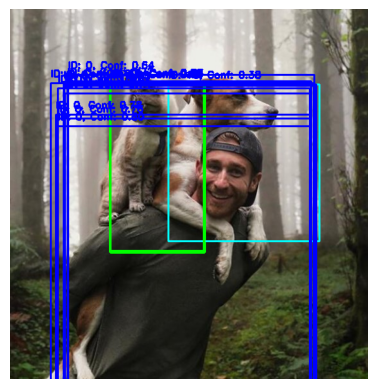

In [14]:
# Process the outputs
boxes, confidences, class_ids = postprocess(output_data)

# Draw the bounding boxes on the image
for box, confidence, class_id in zip(boxes, confidences, class_ids):
    if class_id == 0:
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    if class_id == 15:  # COCO cat
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    if class_id == 16:  # COCO dog
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 2)

    if class_id == 0 or class_id == 15 or class_id == 16: 
        label = f'ID: {class_id}, Conf: {confidence:.2f}'
        cv2.putText(image, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()